In [1]:
import numpy as np
import pandas as pd
import gget
import glob
import networkx as nx
import os
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# Load sc data

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/analysis.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]
adata

AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

# Load isoforms

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/isoforms/isoform_data.parquet"

df = pd.read_parquet(fpath)
df = df[df['cell_id'].isin(adata.obs_names)] # filter out undetected CBs
print(f"{df.shape=}")
df.head()

df.shape=(11373142, 8)


,isoform_id,gene_id,run_id,cell_id,UMI,read_name,gene_name,transcript_name
0,ENST00000483767,ENSG00000188976,Run3x0418,TGTGGCGGTAACGGTG,AAGTTTACCGGG,b43c7b93-2130-42e0-a51d-2819bedeb593,NOC2L,NOC2L-204
1,ENST00000483767,ENSG00000188976,Run3x0418,CTAACTTGTCGTCATA,TTTTGGATCTTT,5887c2fa-b3bd-4a22-b3f8-4ce31b4e9d0d,NOC2L,NOC2L-204
2,ENST00000483767,ENSG00000188976,Run3x0418,AAGATAGAGTTGGGAC,AACGGGTCCTCT,050743c4-d895-45d6-b59a-c5232b6ac1b1,NOC2L,NOC2L-204
3,ENST00000469563,ENSG00000188976,Run3x0418,TATACCTAGTCGGCCT,AACGGTTAGCCG,f24c150f-2a5a-4581-96a7-081d004d28c6,NOC2L,NOC2L-202
4,ENST00000469563,ENSG00000188976,Run3x0418,TGTAAGCGTGTCATTG,AAACTCTAACTT,166e19dc-cd7c-4ee2-b35e-eb3ceb455285,NOC2L,NOC2L-202


# Plot some

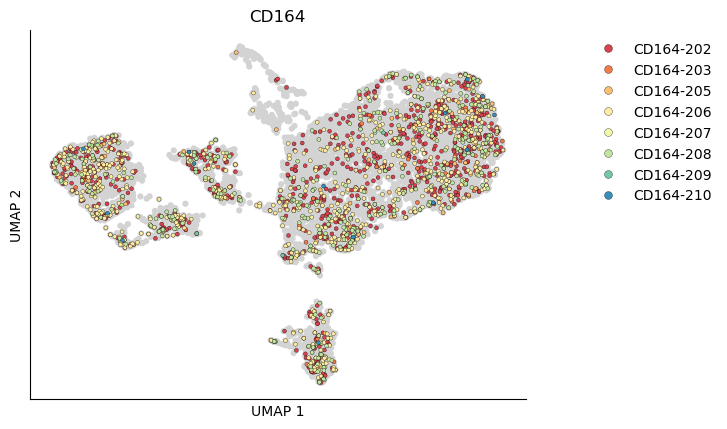

In [4]:
def plot_isoform_umap(adata, df, query, size=15, palette='Spectral'):
    """
    Plots UMAP visualization of gene expression for a given query gene, with customizable parameters.

    Args:
        adata: AnnData object containing the expression data and UMAP coordinates.
        df: DataFrame containing gene annotations (gene_name, transcript_name, etc.).
        query: String representing the query gene name.
        size: Integer controlling the size of the scatterplot markers.
        palette: String or list specifying the color palette for the transcript_name hue.
    """

    pdf = adata.obs.copy()
    pdf = pdf.reset_index()

    query_df = df[df['gene_name'] == query]
    
    if query_df.empty:
        return

    pdf = pd.merge(pdf, query_df, how='left')
    pdf = pdf.sort_values(by='transcript_name')

    sns.scatterplot(
        data=pdf,
        x='UMAP 1',
        y='UMAP 2',
        color='lightgrey',
        zorder=0,
        ec='none',
        s=size,
    )

    sns.scatterplot(
        data=pdf,
        x='UMAP 1',
        y='UMAP 2',
        hue='transcript_name',
        ec='k',
        s=size / 2.5,
        palette=palette,
    )

    plt.xticks([])
    plt.yticks([])

    plt.ylabel('UMAP 2')
    plt.xlabel('UMAP 1')

    sns.despine()

    plt.title(query)
    plt.gca().set_aspect('auto')

    sns.move_legend(
        plt.gca(),
        loc='upper right',
        title="",
        frameon=False,
        bbox_to_anchor=(1.4, 1),
        markerscale=2,
    )
    
plot_isoform_umap(adata, df, query='CD164', size=20)

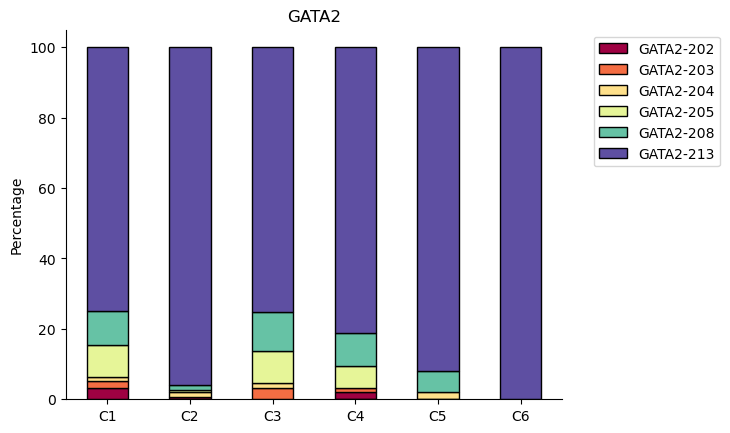

In [5]:
def plot_cluster_expression(adata, df, query, palette='Spectral'):
    """
    Plots stacked bar charts showing the percentage of each cluster expressing each transcript for a given query gene.

    Args:
        adata: AnnData object containing the expression data and UMAP coordinates.
        df: DataFrame containing gene annotations (gene_name, transcript_name, etc.).
        query: String representing the query gene name.
        palette: String or list specifying the color palette for the transcript_name hue.
    """

    pdf = adata.obs.copy()
    pdf = pdf.reset_index()

    query_df = df[df['gene_name'] == query]

    if query_df.empty:
        return

    pdf = pd.merge(pdf, query_df, how='left')
    pdf = pdf.sort_values(by='transcript_name')

    # Group by cluster and transcript, count the number of cells expressing each transcript
    expression_counts = pdf.groupby(['cluster_str', 'transcript_name'], 
                                    observed=True).size().unstack(fill_value=0)

    # Calculate the percentage of cells expressing each transcript within each cluster
    percentage_expression = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 100

    # Plot stacked bar charts
    percentage_expression.plot(
        kind='bar',
        stacked=True,
        colormap=palette,
        ec="k",
    )
    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.title(f'{query}')
    plt.gca().tick_params(axis='x', rotation=0)
    sns.despine()
    plt.legend(
        title='', 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left')
    
    
plot_cluster_expression(adata, df, query='GATA2', palette='Spectral')  

n genes: 8


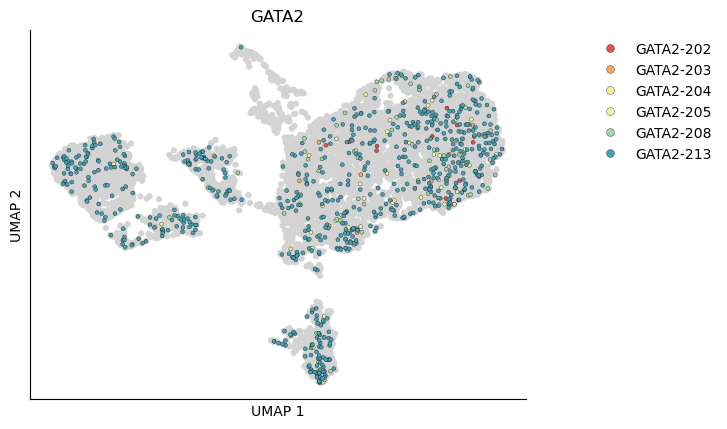

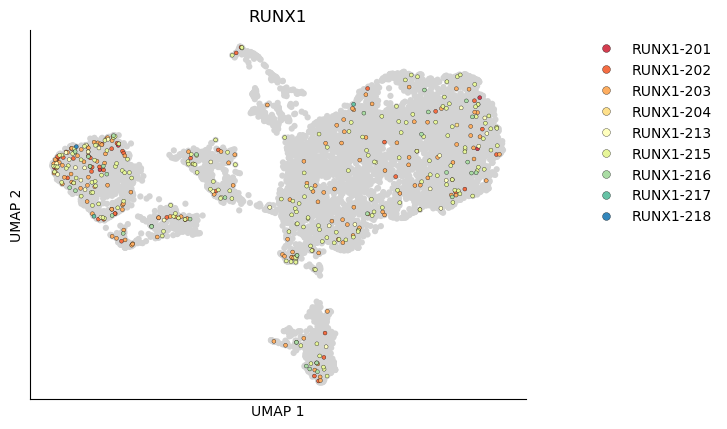

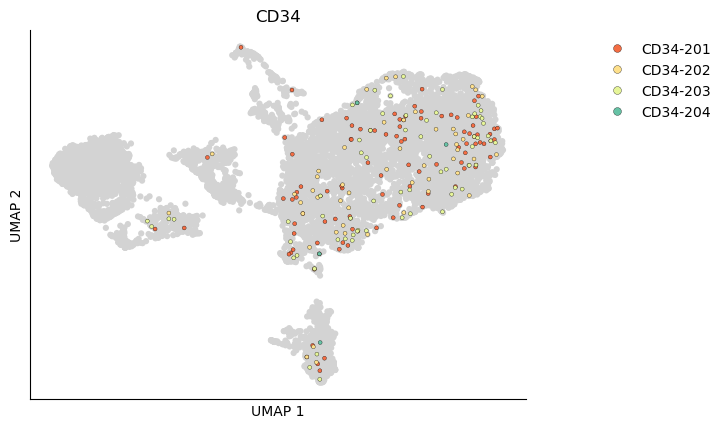

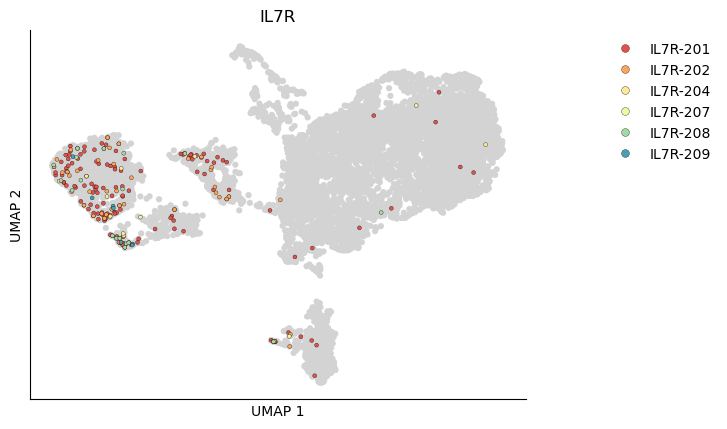

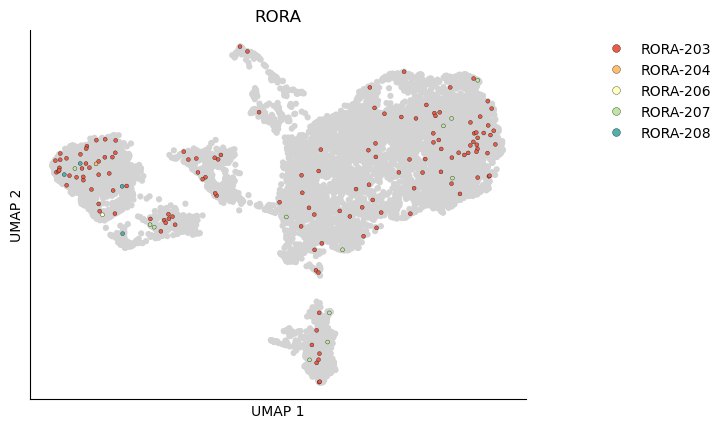

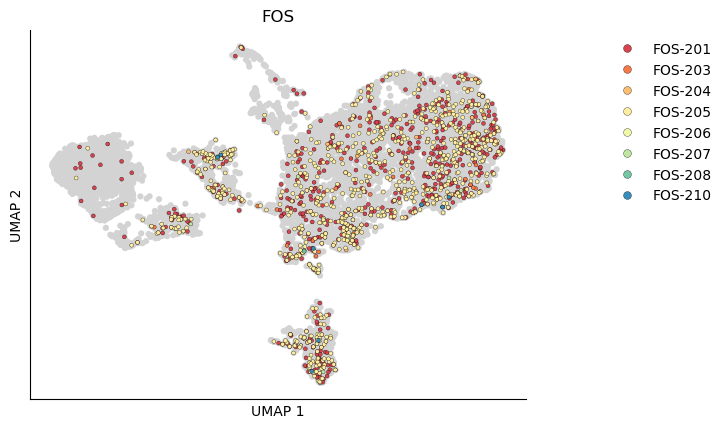

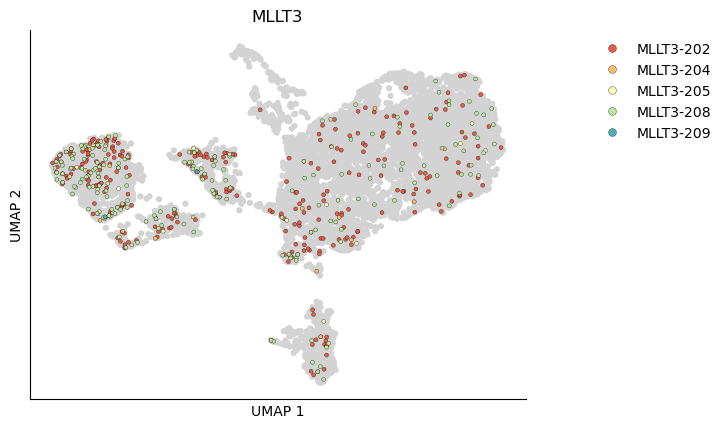

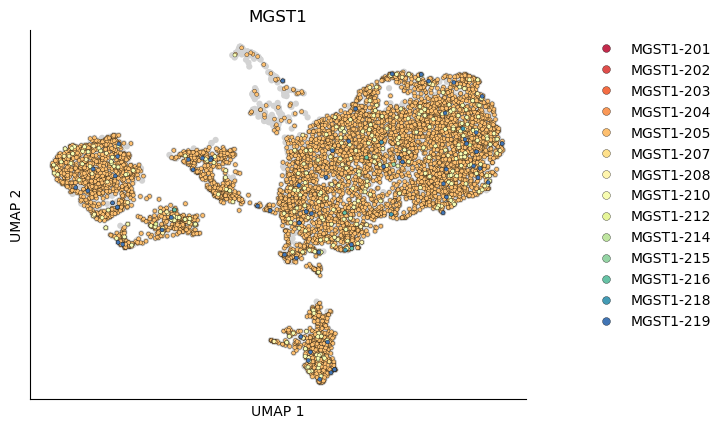

In [6]:
gene_list = [
    'GATA2', 'RUNX1', 'CD34', 'IL7R', 'RORA', 'FOS','MLLT3','MGST1',
]

gene_list = [x for x in gene_list if x in adata.var['gene_name'].values]
print(f"n genes: {len(gene_list)}")

for gene in gene_list:
    plot_isoform_umap(
        adata, 
        df, 
        query=gene, 
        size=20,
    )
    plt.show()

# Differential ISO Explore

In [7]:
df['value'] = 1
df.head()

,isoform_id,gene_id,run_id,cell_id,UMI,read_name,gene_name,transcript_name,value
0,ENST00000483767,ENSG00000188976,Run3x0418,TGTGGCGGTAACGGTG,AAGTTTACCGGG,b43c7b93-2130-42e0-a51d-2819bedeb593,NOC2L,NOC2L-204,1
1,ENST00000483767,ENSG00000188976,Run3x0418,CTAACTTGTCGTCATA,TTTTGGATCTTT,5887c2fa-b3bd-4a22-b3f8-4ce31b4e9d0d,NOC2L,NOC2L-204,1
2,ENST00000483767,ENSG00000188976,Run3x0418,AAGATAGAGTTGGGAC,AACGGGTCCTCT,050743c4-d895-45d6-b59a-c5232b6ac1b1,NOC2L,NOC2L-204,1
3,ENST00000469563,ENSG00000188976,Run3x0418,TATACCTAGTCGGCCT,AACGGTTAGCCG,f24c150f-2a5a-4581-96a7-081d004d28c6,NOC2L,NOC2L-202,1
4,ENST00000469563,ENSG00000188976,Run3x0418,TGTAAGCGTGTCATTG,AAACTCTAACTT,166e19dc-cd7c-4ee2-b35e-eb3ceb455285,NOC2L,NOC2L-202,1


In [8]:
X = pd.pivot_table(
    df, 
    index='cell_id',
    columns='transcript_name',
    values='value',
    fill_value=0.0,
)

print(f"{X.shape=}")
X.head()

X.shape=(8563, 75541)


transcript_name,A1BG-201,A1BG-202,A1BG-203,A1BG-204,A2M-201,A2M-205,A2M-207,A4GALT-201,A4GALT-202,A4GALT-205,...,ZZEF1-209,ZZEF1-210,ZZZ3-201,ZZZ3-202,ZZZ3-204,ZZZ3-205,ZZZ3-206,ZZZ3-209,ZZZ3-210,ZZZ3-211
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGGTTACCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTTGAAGT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTTGTCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAGAAGCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAGGAGGTT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
group_map = dict(zip(adata.obs.index, adata.obs.cluster_str))

X['cluster'] = X.index.map(group_map)
X.head()

transcript_name,A1BG-201,A1BG-202,A1BG-203,A1BG-204,A2M-201,A2M-205,A2M-207,A4GALT-201,A4GALT-202,A4GALT-205,...,ZZEF1-210,ZZZ3-201,ZZZ3-202,ZZZ3-204,ZZZ3-205,ZZZ3-206,ZZZ3-209,ZZZ3-210,ZZZ3-211,cluster
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGGTTACCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C1
AAACCCAAGTTGAAGT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C1
AAACCCAAGTTGTCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C4
AAACCCACAGAAGCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C2
AAACCCACAGGAGGTT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C1


In [10]:
proportions = X.groupby('cluster').mean().T

# DROP C6
proportions = proportions.drop(columns=['C6'])

proportions['std'] = proportions.std(axis=1)
proportions = proportions.sort_values(by='std', ascending=False)

proportions.head(45)

cluster,C1,C2,C3,C4,C5,std
transcript_name,,,,,,
LUM-203,0.048638,0.965753,0.074356,0.101329,0.570470,0.405084
THBS1-201,0.061879,0.910388,0.104215,0.159468,0.749441,0.400697
TNFRSF11B-201,0.042017,0.927511,0.069672,0.046512,0.156600,0.382399
TOP2A-201,0.060351,0.094178,0.042740,0.911960,0.038031,0.382170
UBE2C-204,0.017316,0.050799,0.019906,0.820598,0.020134,0.355157
CD248-201,0.052967,0.742009,0.072600,0.091362,0.675615,0.349680
CKS1B-201,0.101859,0.140982,0.129977,0.855482,0.093960,0.330964
DCN-220,0.017571,0.730023,0.027518,0.049834,0.467562,0.324416
PTTG1-201,0.116119,0.126142,0.148712,0.840532,0.102908,0.321116


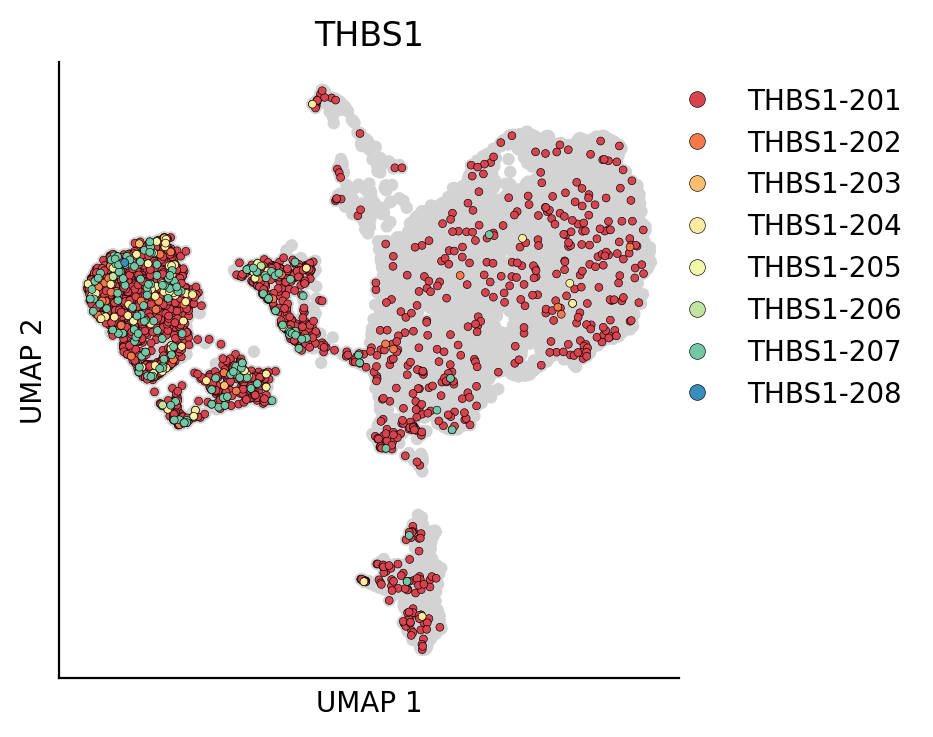

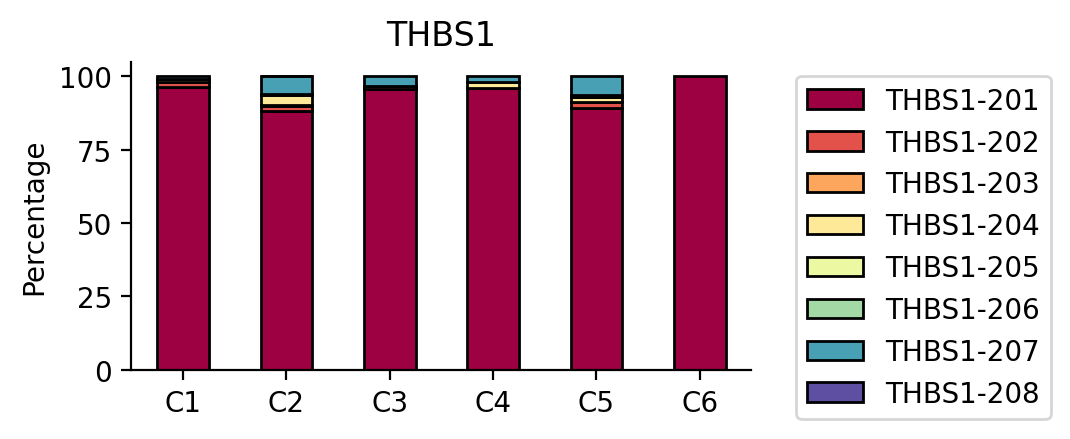

In [11]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

query = 'THBS1'

plot_isoform_umap(adata, df, query=query, size=20)
plt.show()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plot_cluster_expression(adata, df, query)
plt.show()

In [12]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# def find_significant_transcripts(df, alpha=0.05):
#     """
#     Identifies transcript names whose values significantly differ by cluster using ANOVA.

#     Args:
#         df: DataFrame with columns 'transcript_name', 'cluster', and 'value'.
#         alpha: Significance level for the ANOVA test (default: 0.05).

#     Returns:
#         DataFrame: Table of results including transcript_name, F-statistic, and p-value.
#     """

#     def perform_anova(group):
#         """Performs ANOVA on a group of values."""
#         groups = [group[group['cluster'] == cluster]['value'] for cluster in df['cluster'].unique()]
#         # Check if there are enough groups for ANOVA (at least 2)
#         if len(groups) < 2:
#             return pd.Series({'F-statistic': np.nan, 'p-value': np.nan})
#         # Handle the case where a group might be empty
#         groups = [g for g in groups if not g.empty]
#         f_statistic, p_value = f_oneway(*groups)
#         return pd.Series({'F-statistic': f_statistic, 'p-value': p_value})

#     # Group by transcript_name and apply ANOVA
#     results_df = df.groupby('transcript_name').apply(perform_anova)

#     # Filter for statistically significant differences based on alpha
#     significant_transcripts = results_df[results_df['p-value'] < alpha]

#     return significant_transcripts


# test = proportions.copy().reset_index()
# test = test.drop(columns=['std'])
# test = pd.melt(
#     test,
#     id_vars='transcript_name'
# )

# res = find_significant_transcripts(test)
# res.head()

In [ ]:
break

In [ ]:
gene_list = [
    'LMBR1L', 'CHD2', 'UFL1', 'SRF', 'ACE', 'XRCC5', 'TAL1', 'ERCC2',
    'ZFP36', 'MLLT3', 'CDK6', 'MED1', 'SFRP1', 'SH2B3', 'GBA',
    'YJEFN3', 'SNAI2', 'ARIH2', 'WNT1', 'CD34', 'ETV6', 'WNT5A',
    'CEBPA', 'BRCA2', 'RUNX1', 'MECOM', 'SART3', 'SHB', 'NKAP',
    'WNT2B', 'SFRP2', 'BABAM1', 'YTHDF2', 'SEPTIN4', 'GATA2', 'CCN3',
    'ADAR', 'SOX4', 'ARHGEF5', 'FSTL1', 'UBAP2L', 'EMCN', 'OCIAD2',
    'NBEA', 'MYCT1', 'BAP1', 'GPRASP2', 'GLIS2', 'CRISPLD1', 'NLE1',
    'OCIAD1', 'ADGRG1',
]

for gene in gene_list:
    plot_isoform_umap(
        adata, 
        df, 
        query=gene, 
        size=20,
    )
    plt.show()
    


In [ ]:
query = 'CD59'

pdf = adata.obs.copy()
pdf = pdf.reset_index()

query_df = df[df['gene_name'] == query]

pdf = pd.merge(
    pdf, 
    query_df,
    how='left',
)

pdf = pdf.sort_values(by='transcript_name')


size = 15
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=pdf, 
    x='UMAP 1',
    y='UMAP 2',
    color='lightgrey',
    zorder=0,
    ec='none',
    s=size,
)

sns.scatterplot(
    data=pdf, 
    x='UMAP 1',
    y='UMAP 2',
    hue='transcript_name',
    ec='k',
    s= size / 2.5,
    # palette='viridis',
    palette='Spectral',
)

plt.xticks([])
plt.yticks([])

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')

sns.despine()

plt.title(query)
plt.gca().set_aspect('auto')

sns.move_legend(
    plt.gca(),
    loc='upper right',
    title="",
    frameon=False,
    bbox_to_anchor=(1.6, 1),
    markerscale=2,
)

In [ ]:
break

In [ ]:
adata.obs.head()

# filter out the genes we care about

In [ ]:
gene_list = [
    'GATA2',
    'KIT',
    'MPL',
    'LMO2'
]

pdf = df[df['gene_name'].isin(gene_list)]
print(f"{pdf.shape=}")
pdf.head()

In [ ]:
break